# Thay thế t-test BẰNG ước lượng Bayesian 
BS Vương Kiến Thanh

## Đặt vấn đề

Có rất nhiều quy trình suy luận thống kê dùng để so sánh sự khác nhau của 2 nhóm.

Trong thế giới thực, sự khác nhau luôn luôn kèm với noise từ đo lường hoặc do hiện tượng phân phối ngẫu nhiên, và dĩ nhiên những kết luận rút ra được từ data quan sát đôi khi không phù hợp.

Do đó, ta cần một model thống kê.

Phương pháp thông dụng nhất là dùng một kiểm định giả thuyết, bao gồm thiết lập giả thuyết vô hiệu, chọn test phù hợp, tính ra số statistic, xem nó có lớn hơn một ngưỡng cụ thể (hay pvalue <0.05)

Tuy nhiên, để thực hiện những test này không dễ, và kết quả có thể bị diễn đạt sai. Ngoài ra, nhiều người sử dụng những lựa chọn test thống kê thông dụng (nhưng không phù hợp) hơn là dựa vào câu hỏi nghiên cứu.

Một cách tiếp cận hiệu quả và cho nhiều thông tin hơn là ước lượng Bayesian.

Thay vì kiểm định 2 nhóm có khác nhau không, ta ước lượng mức độ của sự khác nhau. Hơn nữa, ta có thể ước lượng được tính bất định của sự khác nhau ấy.

## Ví dụ: Đánh giá hiệu quả của thuốc

Đây là ví dụ ảo. Ví dụ nghiên cứu hiệu quả của thuốc làm tăng IQ của trẻ em.  
Nghiên cứu sẽ thu thập IQ của từng cá nhân trong nhóm dùng thuốc và nhóm dùng placebo.

In [1]:
import arviz as az
import matplotlib.pyplot as plt

import pandas as pd

import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

az.style.use("arviz-darkgrid")
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
y1 = np.array([101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101])
y2 = np.array([99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99])

y = pd.concat([pd.DataFrame({'value':y1, 'group':'drug'}),
           pd.DataFrame({'value':y2, 'group':'placebo'}) ])
y

,value,group
0,101,drug
1,100,drug
2,102,drug
3,104,drug
4,102,drug
...,...,...
37,100,placebo
38,102,placebo
39,99,placebo
40,100,placebo


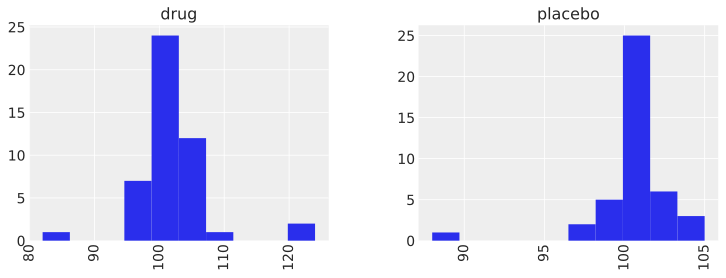

In [3]:
y.hist('value', by='group', figsize=(12, 4));

### Bước 1: Xác định likelihood
Phân phối IQ sẽ tuân theo phân phối student-t. Phân phối student-t tăng sức mạnh của phân tích, vì nó ít nhạy cảm hơn với các outliers.  

Phân phối student-t có 3 parameters: trung bình **mu**, độ lệch chuẩn **sigma**, độ tự do **nu** (tương đương với loc, scale, df).

Ta sẽ áp dụng likelihood này cho 2 nhóm `drug` và `placebo`.

### Bước 2: Xác định priors cho từng parameters.
- **mu ~ Normal(mean_data, std_data $\times$ 2)**  
Vì giả thuyết vô hiệu là 2 nhóm như nhau, nên ta dùng trung bình và độ lệch chuẩn của toàn bộ data. std nhân 2 để cho thấy mức độ thông tin còn ít và không ưu thế một nhóm nào trong 2 nhóm.
- **sigma ~ Uniform(0,10)**  
Giới hạn lại độ biến thiên của IQ.
- **nu ~ Exponential(1/30)**  
Phân phối exponential này có trung bình là 30, là ngưỡng mà phân phối student-t có hình dạng gần giống normal.

In [4]:
mu_m = y.value.mean()
mu_s = y.value.std() * 2
sigma_low = 1
sigma_high = 10

Ta có thể viết model như sau:

$$ 
\begin{align}
y^{(treat)}_i &\sim T(\nu, \mu_1, \sigma_1)  && \quad \text{[likelihood group1]}\\
y^{(placebo)}_i &\sim T(\nu, \mu_2, \sigma_2)  && \quad \text{[likelihood group2]}\\
\mu_1 &\sim N(\bar{x}, 2s)  && \quad \text{[prior mu1]}\\
\mu_2 &\sim N(\bar{x}, 2s)  && \quad \text{[prior mu2]}\\
\sigma_1 &\sim \text{Uniform}(1, 10)  && \quad \text{[prior sigma1]}\\
\sigma_2 &\sim \text{Uniform}(1, 10)  && \quad \text{[prior sigma2]}\\
\nu &\sim \text{Exponential}(^1/_{30})  && \quad \text{[prior nu]}
\end{align}
$$

### Bước 3: Xác định các thông số so sánh cần ước lượng
Để đánh giá sự khác nhau của 2 nhóm, ta cần xác định hiệu của trung bình và độ lệch chuẩn của 2 nhóm.  
Nó được khai báo thông qua hàm `deterministic` .  
Ta cũng có thể đánh giá sự khác nhau bằng *kích thước hiệu ứng* (**effect size**). Con số này có thể khó diễn giải, nhưng nó là hiệu trung bình được hiệu chỉnh bởi độ lệch chuẩn gộp của 2 nhóm (**pooled std**).

$$ 
\begin{align}
&\text{difference of means} &&= \mu_1 - \mu_2  \\
&\text{difference of stds} &&= \sigma_1 - \sigma_2  \\
&\text{effect size} &&= \frac{\mu_1 - \mu_2}{\sqrt{(\sigma_1^2 + \sigma_2^2)/2}}
\end{align}
$$

>Effect size is a quantitative measure of the magnitude of the experimenter effect. The larger the effect size the stronger the relationship between two variables.  
>Cohen suggested that d = 0.2 be considered a 'small' effect size, 0.5 represents a 'medium' effect size and 0.8 a 'large' effect size. This means that if two groups' means don't differ by 0.2 standard deviations or more, the difference is trivial, even if it is statistically significant.  
>
>| Relative size | Effect size |
|-|-|
|Small| <0.2|
|Medium | 0.5|
|Large | > 0.8|

## Numpyro là một probabilistic programming language. Với numpyro, ta có thể tạo ra một Bayesian model một cách dễ dàng.

In [5]:
def model(y1,y2):
    # priors
    group1_mean = numpyro.sample('group1_mean', dist.Normal(mu_m, mu_s))
    group2_mean = numpyro.sample('group2_mean', dist.Normal(mu_m, mu_s))
    group1_std = numpyro.sample('group1_std', dist.Uniform(sigma_low, sigma_high))
    group2_std = numpyro.sample('group2_std', dist.Uniform(sigma_low, sigma_high))
    nu = numpyro.sample('nu', dist.Exponential(1/30))
    # likelihoods
    numpyro.sample('group1', dist.StudentT(nu, group1_mean, group1_std), obs=y1)
    numpyro.sample('group2', dist.StudentT(nu, group2_mean, group2_std), obs=y2)
    # estimate
    diff_of_means = numpyro.deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = numpyro.deterministic('difference of stds', group1_std - group2_std)
    effect_size = numpyro.deterministic(
        'effect size',
        diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2)
    )

### Bước 4: Tính posterior thông qua Markov Chain Monte Carlo (MCMC)
MCMC là một thuật toán lấy mẫu posterior, hay còn gọi là **sampler**. Trong MCMC có rất nhiều sampler, từ đơn giản đến phức tạp: Metropolis Hasting, Gibb, Hamiltonian Monte Carlo (HMC), No U Turn Sampler (NUTS), ....  
**NUTS** là một sampler mạnh và phổ biến, được dùng trong ví dụ này.  

Các bạn có thể tham khảo demo các samplers trong link này:  
https://chi-feng.github.io/mcmc-demo/app.html

Ở đây tôi chọn NUTS, loại bỏ 500 mẫu đầu tiên, lấy 2000 mẫu, chạy 4 lần như vậy (dùng 1 CPU core, 4 tác vụ lần lượt).

In [6]:
tracer = MCMC(NUTS(model), num_warmup=500, num_samples=2000, num_chains=4, chain_method="sequential")

Bắt đầu thu thập posterior.

In [7]:
tracer.run(PRNGKey(0), y1, y2)

sample: 100%|██████████| 2500/2500 [00:05<00:00, 497.37it/s, 7 steps of size 5.50e-01. acc. prob=0.90] 


### Bước 5: Hiển thị kết quả parameters trong posterior sau khi update (có kèm các thông số deterministic).

In [8]:
tracer.print_summary(exclude_deterministic=False)


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
  difference of means      1.02      0.45      1.02      0.26      1.74   8779.88      1.00
   difference of stds      0.93      0.45      0.90      0.23      1.67   7721.10      1.00
          effect size      0.61      0.28      0.60      0.15      1.08   8267.93      1.00
          group1_mean    101.55      0.39    101.56    100.92    102.17   8633.62      1.00
           group1_std      2.12      0.44      2.09      1.41      2.82   6849.61      1.00
          group2_mean    100.54      0.23    100.54    100.17    100.92   8775.77      1.00
           group2_std      1.19      0.15      1.16      1.00      1.40   8132.38      1.00
                   nu      1.97      0.50      1.90      1.19      2.72   6019.32      1.00

Number of divergences: 0


### Vẽ phân phối của từng param

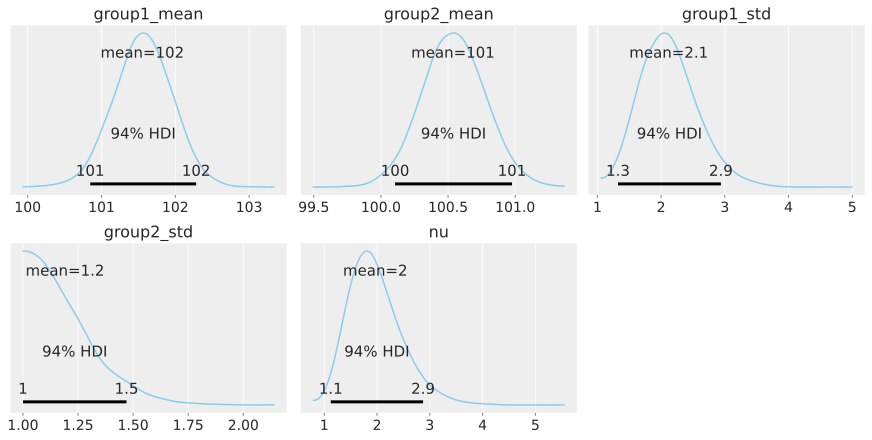

In [9]:
az.plot_posterior(tracer, var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'nu'],
                  color='#87ceeb', figsize=(12,6));

### Và phân phối của các thông số so sánh.
`ref_val` sẽ giúp ta biết được mật độ xác suất của thông số.

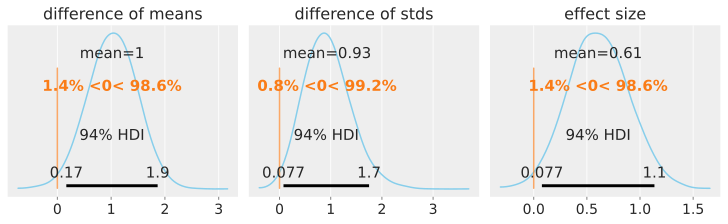

In [10]:
az.plot_posterior(tracer, var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb', figsize=(10,3));

# Kết luận:
Nhìn vào hình, ta kết luận có sự khác nhau có ý nghĩa giữa 2 nhóm.

Với hiệu trung bình, xác suất hiệu trung bình lớn hơn 0 là 98.6%, có nghĩa là trung bình 2 nhóm là khác nhau có ý nghĩa thống kê. Tương tự với hiệu độ lệch chuẩn và kích thước hiệu ứng.

Có thể nói là, thuốc này giúp tăng IQ, cũng như làm tăng độ biến thiên của nó. Có nghĩa là vẫn có cá thể không nhận được lợi ích từ thuốc.

### Bước 6: Kiểm tra độ hội tụ (convergence)
Bởi vì ta dùng 4 chains để chạy MCMC, ta có thể kiểm tra độ hội tụ của kết quả MCMC.  
Và 4 chains này cho kết quả gần giống nhau, nên ta kết luận model đã hội tụ.

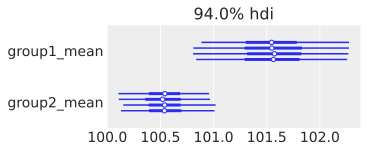

In [11]:
az.plot_forest(tracer, var_names=['group1_mean',
                                'group2_mean'],
               figsize=(5,2));

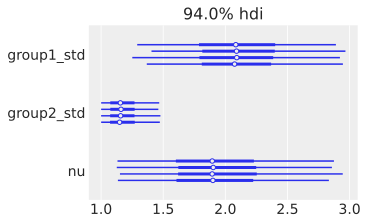

In [12]:
az.plot_forest(tracer, var_names=['group1_std',
                               'group2_std',
                               'nu'],
               figsize=(5,3));

References¶

1. Goodman SN. Toward evidence-based medical statistics. 1: The P value fallacy. Annals of Internal Medicine. 1999;130(12):995-1004. doi:10.7326/0003-4819-130-12-199906150-00008.
2. Johnson D. The insignificance of statistical significance testing. Journal of Wildlife Management. 1999;63(3):763-772.
3. Kruschke JK. Bayesian estimation supersedes the t test. J Exp Psychol Gen. 2013;142(2):573-603. doi:10.1037/a0029146.